# MSc in AI - CE6002 & CS5062 Etivity 1 - EDA & The Learning Problem
Student Name: Michel Danjou

Student ID: 18263461


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Task 1

In [2]:
# Load the data
data = pd.read_csv("bank_et1.csv") 

In [3]:
# Preview the first 5 lines of the data 
data.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


The preview of the first 5 lines of the dataset reveals that it contains **personal and financial information**, along with **marketing  campaign details**. 

We note that the dataset **does not contain gender information** and that the **currency is unknown**.

In [4]:
# Preview the last 5 lines of the data
data.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


The last 5 rows indicates that the dataset is composed of **2000 samples**, with some **missing values**. (poutcome=NaN, pdays=-1)

## Target identification 

The following url provides a description of a similar dataset: https://archive.ics.uci.edu/ml/datasets/bank+marketing
We will assume these descriptions also apply to our dataset. 


The dataset is composed of the following features:

| Feature name | description   | type |
|--------------|---------------|------|
|age           | age (numeric) | numeric |
|job           | job : type of job | categorical|
|marital|marital : marital status | categorical |
|education| education |categorical |
|default|default: has credit in default? |categorical|
|balance| account balance| numeric|
|ratio_bal_ln| ratio of balance to loan | numeric|
|ratio_ln_inc| ratio of loan to income | numeric|
|housing | has housing loan | categorical|
|loan | has personal loan | categorical|
|contact | contact communication type | categorical|
|day | day last contacted| numeric |
|month | month last contacted| numeric |
|duration | duration of last contact| numeric |
|campaign | number of contacts during this campaign| number |
|pdays | number of days since last contact| numeric|
|previous | number of contacts done in previous campaign| numeric|
|poutcome | outcome from previous campaign| categorical|
|subscribed | outcome from current campaign| categorical|

I believe the bank would be interested in **predicting the outcome of a campaign** based on the historical data it possesses.
For this reason I am selecting **subscribed** as my target.


# Task 2

## Calculate statistics for the numerical and categorical attributes

### Numerical statistics

In [5]:
# Print statistical summary for all numerical attributes
data.describe()

,Unnamed: 0,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,577.494589,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,0.000000,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,499.750000,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,999.500000,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,1499.250000,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,1999.000000,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


The **average customer** targeted in the campaign is **41 years old**, with a balance of 1413, ratio balance to income of 0.24, ratio loan to income of 0.48


### Categorical statistics

In [6]:
# Describe the categorical attributes.
data.describe(exclude=[np.number])

,job,marital,education,default,housing,loan,contact,month,poutcome,subscribed
count,1990,2000,1896,2000,2000,2000,1809,2000,1546,2000
unique,11,3,3,2,2,2,2,12,3,2
top,management,married,secondary,no,no,no,cellular,feb,failure,yes
freq,461,1111,995,1985,1037,1750,1663,404,955,1000


The average customer is a **manager, married,** with **secondary education**, has never defaulted, does **not own a house**, has **no loan** and has **not subscribed** yet.

In [7]:
data['job'].value_counts()


management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: job, dtype: int64

In [8]:
data['marital'].value_counts()

married     1111
single       674
divorced     215
Name: marital, dtype: int64

In [9]:
data['education'].value_counts()

secondary    995
tertiary     684
primary      217
Name: education, dtype: int64

In [10]:
data['default'].value_counts()

no     1985
yes      15
Name: default, dtype: int64

In [11]:
data['housing'].value_counts()

no     1037
yes     963
Name: housing, dtype: int64

In [12]:
data['loan'].value_counts()

no     1750
yes     250
Name: loan, dtype: int64

In [13]:
data['contact'].value_counts()

cellular     1663
telephone     146
Name: contact, dtype: int64

In [14]:
data['poutcome'].value_counts()

failure    955
success    444
other      147
Name: poutcome, dtype: int64

In [15]:
data['subscribed'].value_counts()

yes    1000
no     1000
Name: subscribed, dtype: int64

The above categorical drill-downs give us more information about the customer base:
  * The first 3 job categories are **management (461), technician (348), and blue-collar (298)**
  * More than **half** of the customers **are married**, about **a third** are **single** and **a tenth divorced**.
  * About **half** of the customers have **secondary education**, about **a third** have **tertiary education** and around **a tenth** have **primary education**.
  * **Default is rare** at only at 0.75%
  * A little less than **half** of the customers are **home owners**.
  * The **vast majority** of the customers (87.5%) have **no loans**
  * Cellphones are by far the easiest way to contact customers. The dataset has **no contact number** for about **10% of the customers** (191)
  * Around **half of the customers** had a **previous outcome**  classified as a **failure**, and less than a quarter (444) a **success**. The rest were either undetermined (147 other) or blank (454)
  * **Half** of the customers are **subscribed**. 

## Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes

### Numerical attributes plots

#### Customer age distribution

Text(0.5,1,'Number of customers by Age')

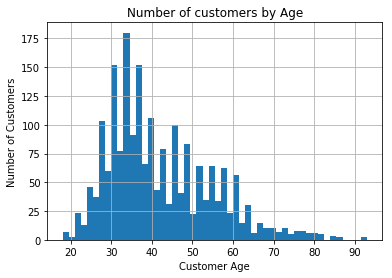

In [16]:
data['age'].hist(bins=50)
plt.xlabel('Customer Age')
plt.ylabel('Number of Customers')
plt.title('Number of customers by Age')

The graph follows a **normal distribution** where the bulk of the customers are between **30 and 50 years old**, representing working age people with probably broad financial needs.

#### Balance statistics
We are interested in analysing the balance statistics given by the boxplot.

Text(0.5,1,'Balance statistics')

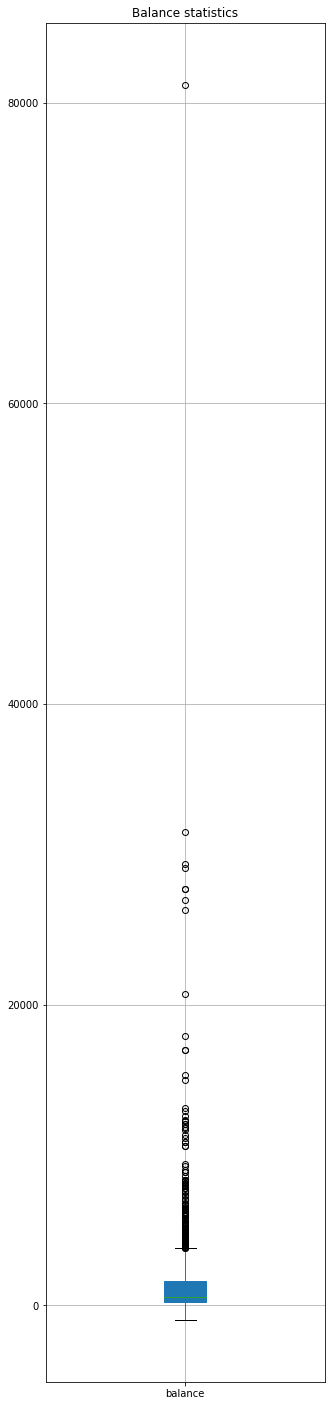

In [17]:
b = data.boxplot(column='balance', figsize=(5,25), patch_artist = True)
plt.title("Balance statistics")

The boxplot highlights an **outlier** which is so high (above 80000) that it makes the Interquantile Range box very small and hard to read. This is the reason why I have stretched the plot to show the boxes in greater detail.

We expect **banks** to be able to **accurately keep track** of their customers **account balances**, so we can assume this **outlier is genuine** and does not need to be removed from the dataset. Having said that, if we had access to a bank representative we would ask for a confirmation as errors happen. 

### Categorical attributes

Frequency Table for job:
housemaid         35
entrepreneur      45
self-employed     64
unemployed        69
student           96
retired          162
services         165
admin.           247
blue-collar      298
technician       348
management       461
Name: job, dtype: int64


Text(0.5,1,'Customers by Job')

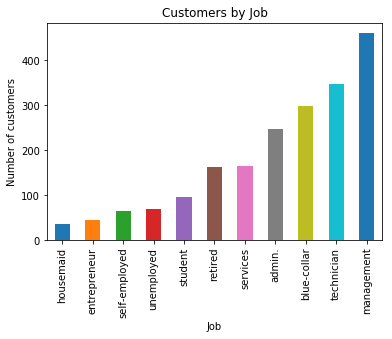

In [18]:
frequency_table = data['job'].value_counts(ascending=True)
print('Frequency Table for job:') 
print(frequency_table)
frequency_table.plot(kind='bar')
plt.xlabel('Job')
plt.ylabel('Number of customers')
plt.title('Customers by Job')

Frequency Table for education:
primary      217
tertiary     684
secondary    995
Name: education, dtype: int64


Text(0.5,1,'Nb customers by Education')

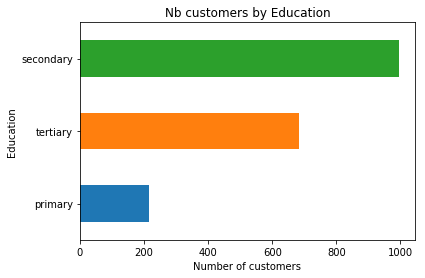

In [19]:
frequency_table = data['education'].value_counts(ascending=True)
print('Frequency Table for education:') 
print(frequency_table)
frequency_table.plot(kind='barh')
plt.xlabel('Number of customers')
plt.ylabel('Education')
plt.title('Nb customers by Education')

This graph confirms that the near majority of customers have **Secondary level education** as their highest education, followed by **tertiary education** and to a much lesser extent **primary education**

## Generate two plots with the combined distribution of attributes

Text(0.5,1,'Housing Loans and Personal Loans statistics')

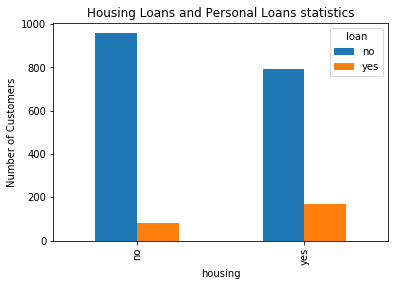

In [20]:
stacked_chart = pd.crosstab(data['housing'], data['loan'])
stacked_chart.plot(kind='bar', stacked=False)
plt.ylabel('Number of Customers')
plt.title("Housing Loans and Personal Loans statistics")

The above chart shows that customers who have a housing loan are more than twice likely to have a personal loan than those who don't have housing loan. 

Text(0.5,1,'Defaulters and subscribers statistics')

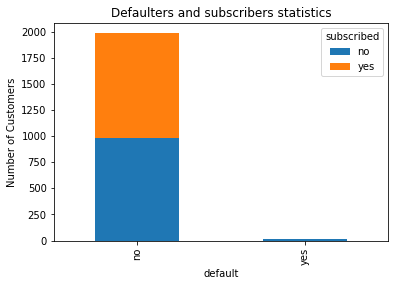

In [21]:
stacked_chart = pd.crosstab(data['default'], data['subscribed'])
stacked_chart.plot(kind='bar', stacked=True)
plt.ylabel('Number of Customers')
plt.title("Defaulters and subscribers statistics")

The above diagram clearly shows that:
* Nearly 50% of the customer base is subscribed.
* There are very little defaulters in the customer base. Maybe defaulters accounts are being transferred to another agency.
* Defaulters are not *subscribed*.

Text(0.5,0.98,'')

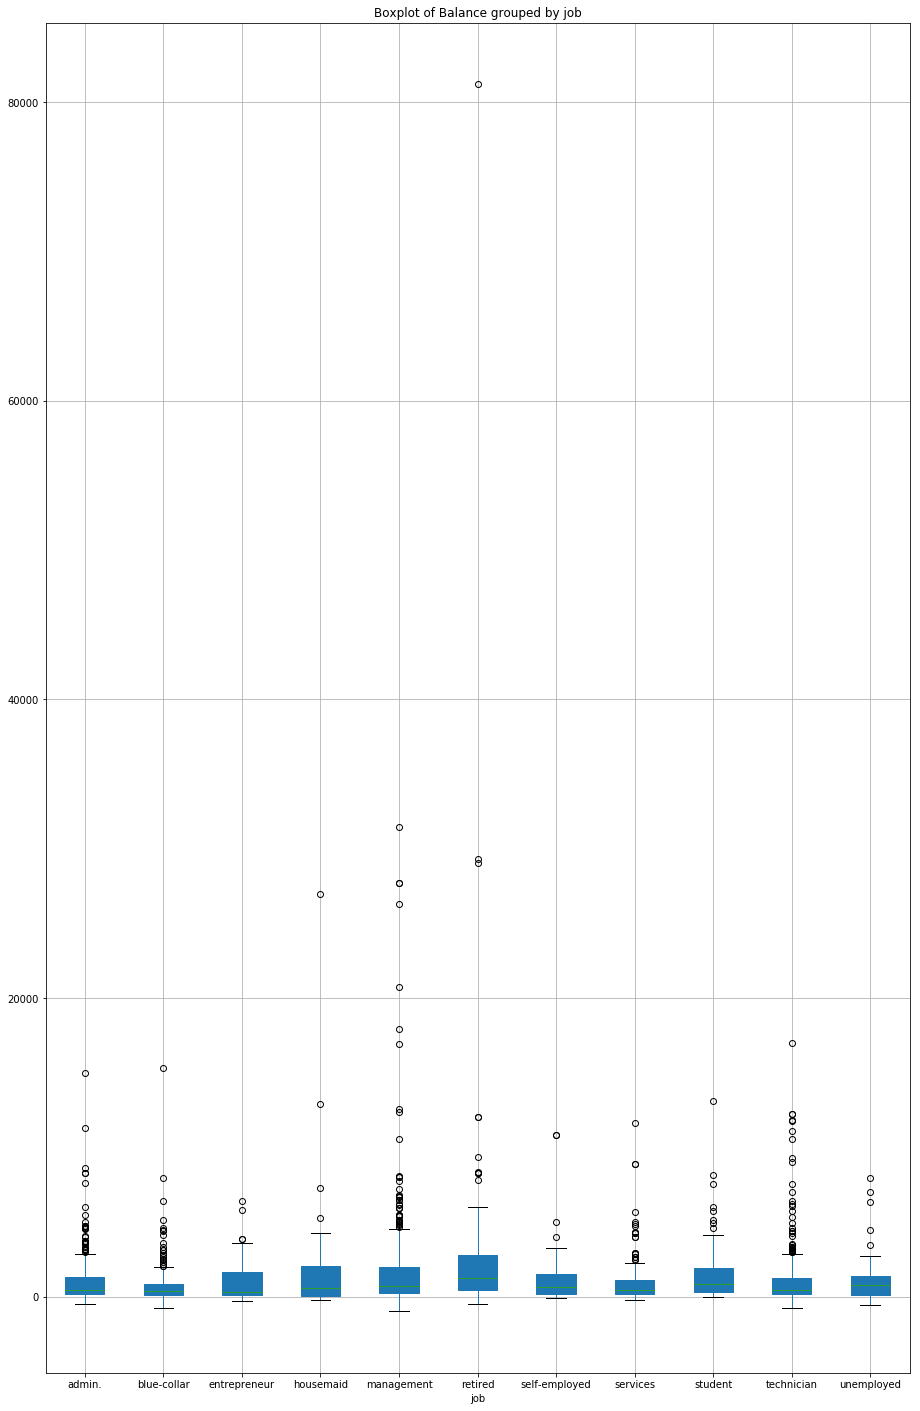

In [22]:
# Boxplots of "balance", grouped by the categorical attribute "job" to investigate which job category pays the best.
data.boxplot(column='balance', by='job', figsize=(15,25), patch_artist = True)

plt.title('Boxplot of Balance grouped by job')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

The boxplot carries a lot of information and a few interesting observations can be derived from it:
* The **retired** population has the **highest bank balance** of all job categories and contains an outlier. 
* The average income for **entrepreneurs** is less than for **housemaids** and **unemployed** which is counter-intuitive. 
* The **management** jobs tend to pay well with a good few outliers very well paid.

## Generate additional plots to indentify two numerical attributes that can potentially be used for predicting the value of the dependent variable chosen in task 1

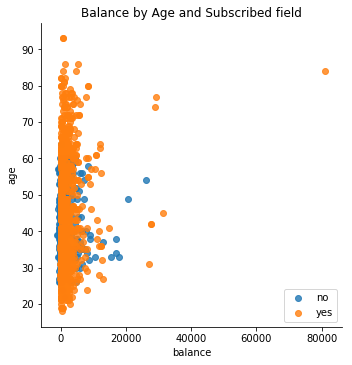

In [23]:
# Balance by Age by Subscribed.
sns.lmplot( x="balance", y="age", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Balance by Age and Subscribed field")
plt.legend(loc='lower right')


Using the *age* and *balance* features will **not allow** us to separate the "yes" and "no" *subscription* clusters as they are overlapping.

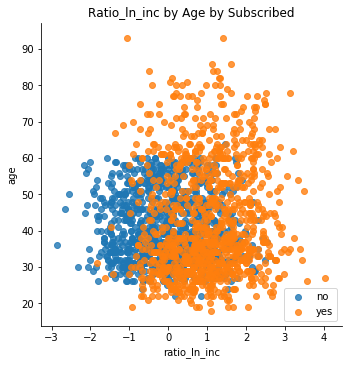

In [24]:
# Ratio_ln_inc by Age by Subscribed
sns.lmplot( x="ratio_ln_inc", y="age", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_ln_inc by Age by Subscribed")
plt.legend(loc='lower right')

The above graph shows 2 clusters with a significant overlap. The distribution of the green point is very spread out which would negatively affect the possibility for PLA to converge.

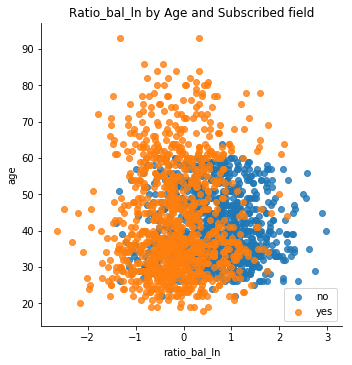

In [25]:
# Ratio_bal_ln by Age by Subscribed.
sns.lmplot( x="ratio_bal_ln", y="age", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Age and Subscribed field")
plt.legend(loc='lower right')

The scatter plot shows 2 clusters with a significant overlap and a very spread out "yes" distribution. **Learning will be difficult.**

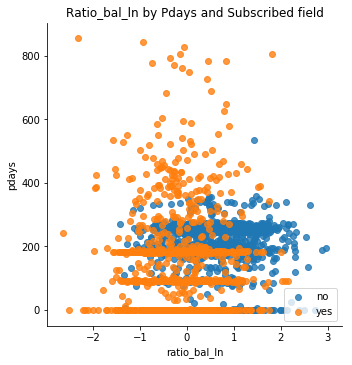

In [26]:
# Ratio_bal_ln by Pdays and Subscribed field
sns.lmplot( x="ratio_bal_ln", y="pdays", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Pdays and Subscribed field")
plt.legend(loc='lower right')

The graph clearly shows the impact of the marketing campaigns on the level of subscriptions which is highlighted by 3 horizontal green lines.

  * **Day 0 subscriptions**: This probably corresponds to the day the customers open an account with the bank. During that process, the bank employee probably up-sales as much as possible resulting in a significant uptake in subscriptions. 

  * **Day 100 subscriptions**: This is probably the result of a phone marketing campaign.

  * **Day 200 subscriptions**: This is probably the result of a phone marketing campaign. 
  
  
Unfortunately, these features do not allow us to create 2 separable clusters and therefore **could not be used for learning**.

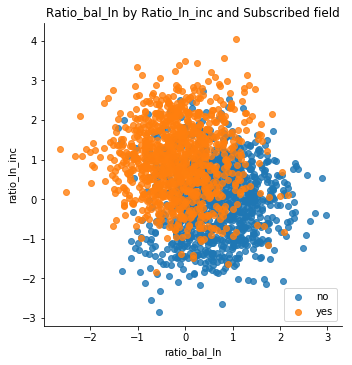

In [27]:
# Ratio_bal_ln by Ratio_ln_inc and Subscribed field
sns.lmplot( x="ratio_bal_ln", y="ratio_ln_inc", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Ratio_ln_inc and Subscribed field")
plt.legend(loc='lower right')

*ratio_bal_ln* and *ratio_ln_inc* are Key Performance Indicators for an account and each one of these KPIs links 2 features. 

  * the *ratio_bal_ln* ratio **links the balance to a loan value**. 
  * the *ratio_ln_inc* ratio **links a loan value to an income**.
  
Because these **KPIs are rich in information**, I believe they could be **prime candidates** for our **input features.**

However, the scatter plot clearly shows 2 significantly overlapping clusters, which means that **learning will be difficult.**

Perhaps a better approach would be to perform a Principal Component Analysis on the dataset and use the two most salient components as our predictors?

# Task 3

Let’s consider a **dataset** composed of 2000 historical data records relating to a bank marketing campaign from which we want to extract a 2-dimensional **input space** that can successfully be used to predict an **output space** representing the subscription rate for a new product. 

Let’s choose two important key performance indicators (KPIs) for the input space: the ratio balance to loan and the ratio loan to income.  These KPIs condense a lot of information and are expected to be good candidates for our leaning algorithm which aims to identify a function approximating an **unknown target function** which links the input space to the output space. 

We use the Perceptron algorithm (with pocket) to identify a **Hypothesis set** from which we extract the most suited function which we refer to as the **Final hypothesis.** 

The Perceptron Learning Algorithm (PLA) is a best suited to learn from data that are linearly separable. It takes an input, aggregates it using weights and returns 1 if the aggregated sum is more than some threshold (bias) or else it returns -1. The main goal of the Perceptron is to learn weights that represent a line which can be used to separate clusters of data. The learning of the weight involves updating them each time the target isn't met. 

Once we have run the Perceptron on the dataset, we compare the margins between the **in-sample error**, calculated from the data used to identify the final hypothesis, and the **out-sample error**, calculated from applying the hypothesis to the output space, **against the Hoeffding bound** and determine if learning is indeed possible. 


# Task 4

In [28]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

In [29]:
def h(x,w):

    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [30]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [31]:
def decision_boundary(weights, x_min, x_max):
   # Return two points on the decision boundary
   return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [32]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        print("\nIteration:", iterations)
        iterations+=1;
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                weights = weights + y*(np.concatenate((bias,x)))
                print("x:{} new weights:{} bias:{} errors:{}".format(x, weights, bias, errors))
                errors+=1;
        if (errors == 0):
            print("Hypothesis found. Nb iterations:", iterations)
            break
    return weights, iterations

In [33]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

## Running the PLA against the sample dataset generated with make_blobs()

Using the dataset generated by *make_blobs()*, The PLA sometimes converge on the first iteration, sometimes it does not converge at all. The **PLA will not converge** to a solution **if the data are not linearly separable**. This is the reason why I plot the dataset before running the PLA as I want to know in advance if the PLA will succeed or not.

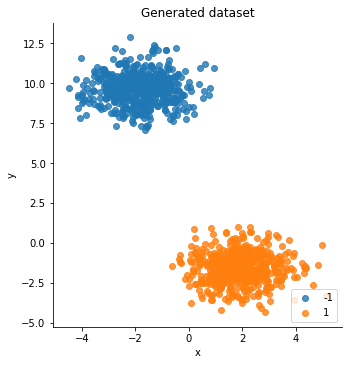

In [34]:
blob_df = pd.DataFrame({'x':X[:,0], 'y':X[:,1], 'c':y})
sns.lmplot( x="x", y="y", data=blob_df, fit_reg=False, hue='c', legend=False)

# Legend and title
ax = plt.gca()
ax.set_title("Generated dataset")
plt.legend(loc='lower right')

<span style="color:red">**IMPORTANT**: If the cell below does not converge, this is because the generated dataset is not linearly separable (see above graph). Please stop the cell and re-run make_blob() </span>

In [35]:
# Run the PLA against the sample dataset
w = [1,1,1]
weights = np.array(w)

best_weights, iterations = pla(X, y, weights)


Iteration: 0
x:[-1.58928161  7.35001815] new weights:[ 0.          2.58928161 -6.35001815] bias:[1] errors:0
x:[2.28764503 0.98605743] new weights:[ 1.          4.87692664 -5.36396072] bias:[1] errors:1
x:[0.19072403 0.86779089] new weights:[ 2.          5.06765067 -4.49616983] bias:[1] errors:2

Iteration: 1
x:[0.19072403 0.86779089] new weights:[ 3.          5.25837471 -3.62837894] bias:[1] errors:0

Iteration: 2
Hypothesis found. Nb iterations: 3


The PLA algorithm as converged to a final hypothesis (weights) which we can use to deduct a **decision boundary** separating the two clusters. 

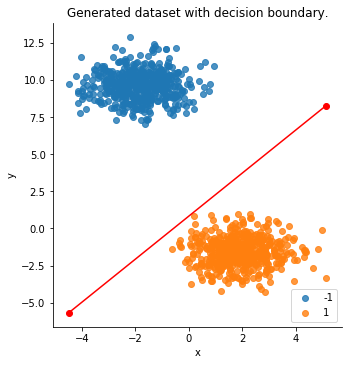

In [36]:
blob_df = pd.DataFrame({'x':X[:,0], 'y':X[:,1], 'c':y})
sns.lmplot( x="x", y="y", data=blob_df, fit_reg=False, hue='c', legend=False)

# Legend and title
ax = plt.gca()
ax.set_title("Generated dataset with decision boundary.")
plt.legend(loc='lower right')

x_min = min(X[:,0])
x_max = max(X[:,0])
y_min, y_max = decision_boundary(best_weights, x_min, x_max)

plt.plot([x_min, x_max], [y_min, y_max], 'ro-')
plt.show()

The above plot clearly shows that the weights generated by the PLA **successfully define a decision boundary** between the two dataset.

## Improving the PLA

The main problems of the given PLA are:  
  * It **only stops** if it can calculate an **error of zero** and therefore **does not work on non linearly separable data**.
  * Even if we managed to stop the PLA after a certain number of iterations, it might not return the best weights it has encountered.
  
The PLA can be improved as follows:
  * Implement a parameter which controls how many times the PLA is executed to avoid an infinite loop when dealing with non linear data.
  * Implement the Pocket Algorithm which stores a copy of the best weights as it progresses.
  
The Pocket Algorithm **checks the overall error rate each time** it detects that a set of **weights no longer matches the target**, and **memorizes** those weights **if** they correspond to the **lowest error** on the entire training set.

Although this implementation works well on our dataset, I am not convinced it would scale because because of the number of times the error function is executed on the entire dataset.

I have decided to keep the *if (errors == 0)* block of code in case the Pocket Algorithm is executed on a linearly separable data which are proven to converge to a solution.

Below is my implementation of the Pocket Algorithm.

In [37]:
def pocket(training_in, training_out, weights, max_iterations):
    bias = np.array([1])
    iterations=0

    # initialise the pocket algorithm variables
    best_weights = weights
    best_weights_iteration = 0
    best_e = calc_error(training_in, training_out, weights)
    
    while iterations < max_iterations:
        errors = 0;
        iterations+=1;
        print("Iteration:{}/{}".format(iterations, max_iterations))
        
        for x,y in zip(training_in, training_out):           
            if (h(x,weights)!=y):
                
                # pocket best results
                e = calc_error(training_in, training_out, weights)
                if (e < best_e):
                    best_e = e
                    best_weights = weights
                    best_weights_iteration = iterations
                    print("Pocketing weights:{} e:{} found at iterations:{}".format(best_weights, best_e, best_weights_iteration))
                
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;                
            
        if (errors == 0):
            print("Hypothesis found. Nb iterations:", iterations)
            break
            
    return best_weights, best_weights_iteration, best_e, iterations 

## Running the Pocket Algorithm on the bank dataset

Start by converting the *subscribed* target from a purely categorical data (yes/no) to a numeric (1/-1)

In [38]:
data['subscribed_code'] = data['subscribed'].map({'yes': 1, 'no': -1})

We remember from task 1 that all the **non-subscribers** were listed on the **first part of the data set** and all the **subscribers** were on the **second part**. 
Later on we will **shuffle** the data, but for now, we simply want to verify that the conversion from categorical to numerical was successful for both subscribers and non-subscribers, so we print the head and tail of the dataset.



In [39]:
data[["subscribed", "subscribed_code"]].head(5)

,subscribed,subscribed_code
0,no,-1
1,no,-1
2,no,-1
3,no,-1
4,no,-1


In [40]:
data[["subscribed", "subscribed_code"]].tail(5)

,subscribed,subscribed_code
1995,yes,1
1996,yes,1
1997,yes,1
1998,yes,1
1999,yes,1


While studying the Etivity, I noted that **low weight values** help the algorithm **converge faster** towards the solution. This is the reason why I chose to initialise the weights with a **random uniform distribution between -1 and 1**.

In [41]:
# Generate random weights
def generate_weights():
    weights = np.array([np.random.uniform(-1,1) for i in range(3)])
    print("Random weights:", weights)
    return weights


Before runnning the PLA we need to:
  * Initialise the weights
  * Define how many iterations of the PLA will be executed 
  * **Shuffle** the data to avoid bias
  * **Split the data** between a **training dataset** and a **testing dataset**


In [42]:
# Initiatialise the weights with random values
weights = generate_weights()

# Number of iterations before exiting the PLA.
max_iterations = 10

# Use 'ratio_bal_ln' and 'ratio_ln_inc' as our inputs
X = data[['ratio_bal_ln', 'ratio_ln_inc']].values

# Use 'subscribed_code' as the target
y = data['subscribed_code'].values

# Shuffle the data
X_shuffled, y_shuffled = shuffle(X, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
print ("X_train.shape:{}, y_train.shape:{}".format(X_train.shape, y_train.shape))
print ("X_test.shape :{}, y_test.shape :{}".format(X_test.shape, y_test.shape))

Random weights: [ 0.93553267  0.37446318 -0.3205062 ]
X_train.shape:(1600, 2), y_train.shape:(1600,)
X_test.shape :(400, 2), y_test.shape :(400,)


### Apply the Pocket Algorithm on the training set to determine Ein

In [43]:
best_weights, best_weights_iteration, best_e, total_iterations = \
pocket(X_train, y_train, weights, max_iterations)

print("="*80)
print("Best weights                   :", best_weights)
print("Best weights found at iteration:", best_weights_iteration)
print("Best e (Ein)                   :", best_e)


Iteration:1/10
Pocketing weights:[-2.06446733  0.22193484  0.27848563] e:0.50875 found at iterations:1
Pocketing weights:[-2.06446733 -0.61978967  0.44744919] e:0.505625 found at iterations:1
Pocketing weights:[-1.06446733 -0.53113455  1.00383573] e:0.294375 found at iterations:1
Pocketing weights:[-0.06446733 -0.29681093  1.43405692] e:0.285625 found at iterations:1
Pocketing weights:[-0.06446733 -0.70425314  1.06305694] e:0.23375 found at iterations:1
Pocketing weights:[-0.06446733 -0.67726368  0.81458237] e:0.220625 found at iterations:1
Pocketing weights:[-0.06446733 -1.66216475  1.17749501] e:0.216875 found at iterations:1
Pocketing weights:[-0.06446733 -1.78484801  1.40838129] e:0.215 found at iterations:1
Pocketing weights:[-0.06446733 -1.93017365  1.82385683] e:0.214375 found at iterations:1
Pocketing weights:[-0.06446733 -1.25341081  1.23409313] e:0.21375 found at iterations:1
Pocketing weights:[-0.06446733 -1.69619531  1.53887669] e:0.213125 found at iterations:1
Pocketing we

Althought the the **in sample data are not linearly separable**, the Pocket Algorithm managed to generate a set of weights corresponding to an **error rate** of around **21%**. This is impressive considering the overlap between the clusters, but might not be sufficient from an **application domain point of view**, in this case a bank.

### Apply the Weights found by the Pocket Algorithm to the testing data to determine Eout

In [44]:
error = calc_error(X_test, y_test, best_weights)
print("Eout:", error)


Eout: 0.2375


We notice that the **in sample error is close to the out sample error**  which is one of the signs of learning.

### Plot the line separating the two clusters

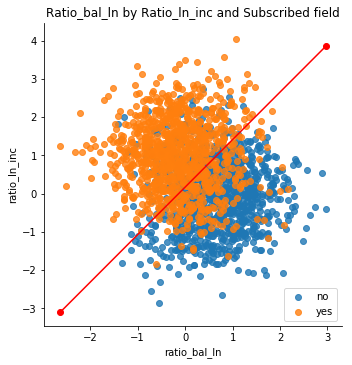

In [45]:
sns.lmplot( x="ratio_bal_ln", y="ratio_ln_inc", data=data, fit_reg=False, hue='subscribed', legend=False)
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Ratio_ln_inc and Subscribed field")
plt.legend(loc='lower right')

x_min = min(X[:,0])
x_max = max(X[:,0])
y_min, y_max = decision_boundary(best_weights, x_min, x_max)

plt.plot([x_min, x_max], [y_min, y_max], 'ro-')
plt.show()

In the above graph, the <span style="color:red">red line</span>  represents the **decision boundary** derived from the weights returned by the Pocket algorithm. It is clear that the **data are not linearly separable** and therefore no hypothesis (weights) can perfectly separate the clusters. The **classification error** can only be **high**.

### Plotting P[Ein - Eout]

In order to plot P[Ein-Eout] we need to run the Pocket Algorithm (Ein) and the Calc_error(best_weights) multiple times.

In [46]:
# Experiment
def experiment(X_data, y_data):
    best_weights, best_weights_iteration, best_e, total_iterations = \
        pocket(X_data, y_data, generate_weights(), max_iterations)
    return {"error":best_e, "weights":best_weights}

Define a variable **M** which represents to the number of times we want to **repeat the experiment**. In the online lectures, this is akin to the **"number of bins"**.

Ideally M should be high but this is not feasible with my computer, so I choose a relatively low but still educational value of 10 instead.

In [47]:
M = 10

In [48]:
Eins = []
Eouts = []
for e in range(M):
    print("\nSimulate Bin #:{}/{}".format(e+1,M))
    
    # shuffle and re-split before each experiment
    X_shuffled, y_shuffled = shuffle(X, y, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
    
    results = experiment(X_train, y_train)
    print("results.['error']:", results['error'])
    print("results.['weights']:", results['weights'])
    
    Ein = results['error']
    Eout = calc_error(X_test, y_test, results['weights'])

    Eins.append(Ein)
    Eouts.append(Eout)

print("Eins:", Eins)
print("Eouts:", Eouts)



Simulate Bin #:1/10
Random weights: [0.24275829 0.19439166 0.82174525]
Iteration:1/10
Pocketing weights:[0.24275829 0.29787184 2.35284381] e:0.355625 found at iterations:1
Pocketing weights:[-0.75724171  0.01240164  1.80367724] e:0.305 found at iterations:1
Pocketing weights:[-0.75724171 -1.92243168  1.58119945] e:0.2225 found at iterations:1
Pocketing weights:[ 0.24275829 -1.3787795   0.77560318] e:0.22125 found at iterations:1
Pocketing weights:[ 0.24275829 -2.05504817  1.29537291] e:0.21875 found at iterations:1
Pocketing weights:[ 0.24275829 -3.33687697  2.55531925] e:0.21625 found at iterations:1
Pocketing weights:[ 0.24275829 -2.62381348  1.97679537] e:0.215625 found at iterations:1
Pocketing weights:[ 0.24275829 -2.23184317  1.82259555] e:0.215 found at iterations:1
Pocketing weights:[ 0.24275829 -2.20740064  1.78619948] e:0.214375 found at iterations:1
Iteration:2/10
Iteration:3/10
Iteration:4/10
Pocketing weights:[ 0.24275829 -2.43752039  1.75999862] e:0.21375 found at iterat

Iteration:3/10
Iteration:4/10
Iteration:5/10
Iteration:6/10
Iteration:7/10
Iteration:8/10
Iteration:9/10
Iteration:10/10
results.['error']: 0.211875
results.['weights']: [ 0.16040734 -1.46538531  1.39606247]

Simulate Bin #:9/10
Random weights: [0.27114471 0.36886548 0.992927  ]
Iteration:1/10
Pocketing weights:[ 0.27114471 -0.21039259  0.61982691] e:0.315 found at iterations:1
Pocketing weights:[ 0.27114471 -1.65957814  0.24645899] e:0.26125 found at iterations:1
Pocketing weights:[-0.72885529 -1.76817689  1.34694938] e:0.2275 found at iterations:1
Pocketing weights:[-0.72885529 -2.29093195  1.52437212] e:0.22375 found at iterations:1
Pocketing weights:[ 0.27114471 -2.43941505  1.99374829] e:0.2225 found at iterations:1
Pocketing weights:[-0.72885529 -1.83092578  2.15780958] e:0.221875 found at iterations:1
Pocketing weights:[-0.72885529 -1.97579556  1.72011645] e:0.218125 found at iterations:1
Iteration:2/10
Pocketing weights:[-0.72885529 -3.04560703  2.64450811] e:0.214375 found at 

#### Eins and Eouts distribution

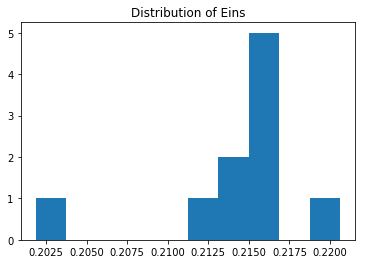

In [49]:
plt.hist(Eins)
plt.title('Distribution of Eins')
plt.show()

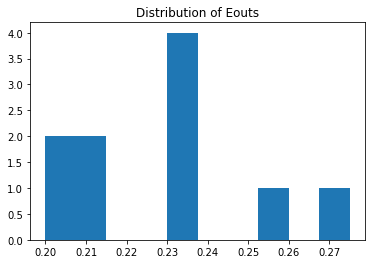

In [50]:
plt.hist(Eouts)
plt.title('Distribution of Eouts')
plt.show()

We can see that both Ein and Eout are mostly concentrated within the same low-twenties range with Eout sometimes spiking in the high-twenties.

Let's calculate and plot the probability of the difference between Ein and Eout in relation to epsilon and the Hoeffding bound.

In [51]:
# Calculate probabily of epsilon
prob_epsilon=[]
epsilons = np.arange(0, 1, 0.01)

for e in epsilons:   
    counter = 0
    for i in range(M):
        if abs(Eins[i] - Eouts[i])>e:
               counter +=1
    prob_epsilon.append(counter/M)           

N = len(X)

print("epsilon proba. dist:", prob_epsilon)
print("M (experiment repeats):", M)
print("N (nb samples):", N)


epsilon proba. dist: [0.9, 0.7, 0.5, 0.2, 0.2, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
M (experiment repeats): 10
N (nb samples): 2000


<function matplotlib.pyplot.show(*args, **kw)>

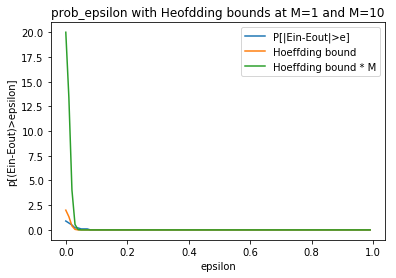

In [52]:
plt.figure()
plt.plot(epsilons, prob_epsilon, label='P[|Ein-Eout|>e]')
plt.plot(epsilons, [2*math.exp(-2*e**2*N) for e in epsilons], label='Hoeffding bound')
plt.plot(epsilons, [2*M*math.exp(-2*e**2*N) for e in epsilons], label="Hoeffding bound * M")
plt.xlabel('epsilon')
plt.ylabel('p[(Ein-Eout)>epsilon]')
plt.title('prob_epsilon with Heofdding bounds at M=1 and M=10')
plt.legend(loc='upper right')
plt.show


We can see that all the curves are converging towards zero as epsilon increases which is expected. Let's zoom in around the area where x=0 and y=0.

<function matplotlib.pyplot.show(*args, **kw)>

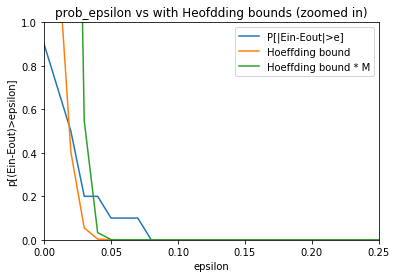

In [55]:
plt.figure()
plt.plot(epsilons, prob_epsilon, label='P[|Ein-Eout|>e]')
plt.plot(epsilons, [2*math.exp(-2*e**2*N) for e in epsilons], label='Hoeffding bound')
plt.plot(epsilons, [2*M*math.exp(-2*e**2*N) for e in epsilons], label="Hoeffding bound * M")

axes = plt.gca()
axes.set_xlim([0,0.25])
axes.set_ylim([0,1])

plt.xlabel('epsilon')
plt.ylabel('p[(Ein-Eout)>epsilon]')
plt.title('prob_epsilon vs with Heofdding bounds (zoomed in)')
plt.legend(loc='upper right')
plt.show



**Notes**
  * There are 3 lines ploted above.
    * P[|Ein-Eout|]>epsilon
    * Hoeffding bounds (curve with a value of 2 when epsilon is 0)
    * Hoeffding bounds for "multiple bins" (curve with a value of 20 when epsilon is 0)
    
**Observations**  
  * I ran the above cell multiple times and noticed that P(Ein-Eout) line **does not always remain under the Hoeffding bounds**, so I can **empirically** deduct that **Heoffding does not apply** to this problem.
  
**Reflection at epsilon close to zero**
  * When epsilon is close to zero, the probability P[|Ein-Eout|]>epsilon is close to 1 which is correct.
  * The Heoffding bound and the M x Heoffding are 2 and 20 respectively, which is correct.
  
**Reflection at the elbow**
  * **Most of the times**, P[|Ein-Eout|]>epsilon follows the curve of the elbow in the Hoeffding bound which is located just before epsilon 0.05. This is the point where our model breaks down. 
  
**Reflection at epsilon close to 1**
  * When epsilon tends to 1, both **Hoeffding curves tend to 0** because exp(-2*e^2*N) is then equivalent to exp(-N) and N is quite big.
  * More importantly the chances that Eout will deviate from Ein are close to zero as well. This means that, as the number of samples grows, so is our confidence that **Eout will track Ein**.
  
**Are we learning?**
  * We were able to see that **Eout often tracks Ein** which is one condition of learning, but that its difference compared to epsilon sometimes crosses the Hoeffding bound.
  * Another condition of learning is the **value of Ein**. With 21% error rate, our weights are clearly better than pure chance (50%) but **might not be enough in the context of the bank**. 
  
As a result we can only say that **we are not really learning yet**

Our model needs to be improved.